In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import numpy as np
from scipy.stats import poisson

In [17]:
df = pd.read_csv('spx.csv', sep=',')

In [18]:
df = df.set_index('Date')
df.index = pd.DatetimeIndex(df.index)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2022-07-25,3966.84,--,3965.72,3975.30,3943.46
2022-07-22,3961.63,--,3998.43,4012.44,3938.86
2022-07-21,3998.95,--,3955.47,3999.29,3927.64
2022-07-20,3959.90,--,3935.32,3974.13,3922.03
2022-07-19,3936.69,--,3860.73,3939.81,3860.73


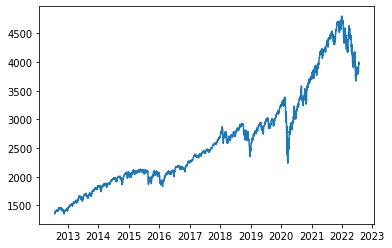

In [19]:
plt.plot(df['Close/Last'])

In [89]:
# Function to calculate the power-law with constants a and b
def weier(x, a, *params):
    k = 100
    y = np.zeros(len(x))
    for j in range(0, int(len(params)/2)):
        for i in range(0,k):
            y += np.power(params[j],i)*np.cos(np.power(params[int(len(params)/2)+j],i)*np.pi*x) 
    return a*y

In [90]:
func = weier
p0 = [1, 0.5, 0.5, 7, 7] # exponential, power law
#p0 = [1]
#p0 = [1., 0., 1.] # gauss

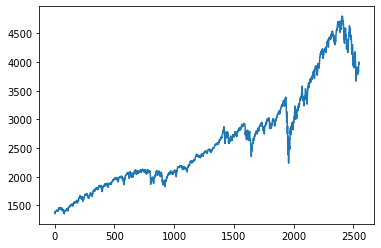

In [91]:
# Prepare data for fitting
#x_data = x_data / len(x_data)
tmp_data = df['Close/Last'].copy()[::-1] #counts #last['score']
#tmp_data = tmp_data / sum(tmp_data)
x_data = [i for i in range(1, len(tmp_data)+1)]
x_data = np.float64(x_data)
plt.plot(x_data, tmp_data)

In [92]:
tmp_data[tmp_data == 0] = 1e-18
y_data = tmp_data.astype(np.float64).to_numpy()
# Fit the data
pars, cov = curve_fit(f=func, xdata=x_data, ydata=y_data, p0=p0, bounds=(-np.inf, np.inf))
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
print(pars)
print(stdevs)

/tmp/ipykernel_76524/467068958.py:7: RuntimeWarning: overflow encountered in power
  y += np.power(params[j],i)*np.cos(np.power(params[int(len(params)/2)+j],i)*np.pi*x)
/tmp/ipykernel_76524/467068958.py:7: RuntimeWarning: invalid value encountered in add
  y += np.power(params[j],i)*np.cos(np.power(params[int(len(params)/2)+j],i)*np.pi*x)


[-0.48396527  0.23555495  0.19451893  7.00000048  7.00000047]
[ 22922.16840908 117757.59357416  71276.05096872    506.95970431
   3001.34693291]


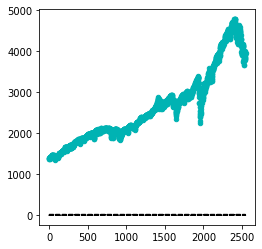

In [93]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0, 0, 1, 1])
# Set the y-axis scaling to logarithmic
#ax.set_yscale('log')
# Set the y-ticks
#ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))# Set the y-axis limits
#ax.set_ylim(0.1, 1000)
# Plot the data
ax.scatter(x_data, y_data, s=20, color='#00b3b3', label='Data')
# Plot the fit data as an overlay on the scatter data
ax.plot(x_data, func(x_data, *pars), linestyle='--', linewidth=2, color='black')

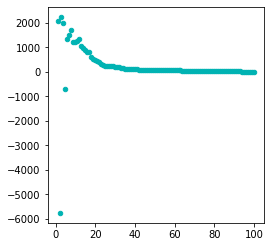

In [50]:
# Residuals
res = y_data - func(x_data, *pars)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(x_data, res, s=20, color='#00b3b3', label='Residuals')

Why the residuals are so ugly, even if the distribution of interactions clearly is exponential?

In any case, a few posts got nearly 80% of all interactions. 

Experiment: a post on reddit gets a percentage of total interactions over the period of time.

Null hypothesis: data distribution == a certain distribution. We test several distributions, keeping the one with the highest p-value.

p-value = P(observing data | data is from distribution) 


If p-value > 0.05, significant probability that the null hypothesis is correct, because the probability of observing this data if the distribution is genextreme is high.

In [64]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["invgamma"] #, "levy", "levy_l", "genextreme", "chi2"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    #print("Best fitting distribution: "+str(best_dist))
    #print("Best p value: "+ str(best_p))
    #print("Parameters for the best fit: "+ str(params[best_dist]))
    #print()

    return best_dist, best_p, params[best_dist]

/home/bedef/Projects/memes_power_law/venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for invgamma = 0.3905579010012471


/home/bedef/Projects/memes_power_law/venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for invgamma = 0.8577771709620977


/home/bedef/Projects/memes_power_law/venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for invgamma = 0.5918857756806387


/home/bedef/Projects/memes_power_law/venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for invgamma = 0.8089234730958611
[('invgamma', 0.3905579010012471, (0.8744117985416577, -7.287430619760561e-05, 0.0002817791190800786)), ('invgamma', 0.8577771709620977, (0.6838997739307331, -4.8708284457367636e-05, 0.00028579799359807986)), ('invgamma', 0.5918857756806387, (0.6560786533621568, -6.866784098521482e-07, 0.00020101575174450082)), ('invgamma', 0.8089234730958611, (0.7446103301695746, -8.012514673333503e-06, 0.00034015175464681337))]


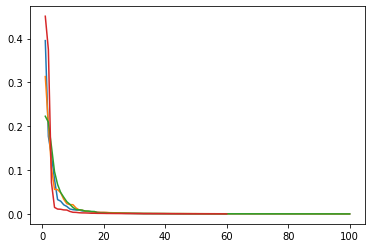

In [89]:
import os
#np.seterr('raise')
files = os.listdir('./ec2/')
pvalues = []
tmp = []
for f in files:
    tmp = pd.read_csv('ec2/'+f, sep=';')
    tmp.dropna()
    tmp['interactions'] = tmp['upvotes'] + tmp['downvotes']
    tmp = tmp.set_index('time')
    tmp.index = pd.DatetimeIndex(tmp.index)
    tmp =  tmp[tmp.index == max(tmp.index)].sort_values(by='interactions',ascending=False)
    df2 = tmp['interactions']
    tmp = df2
    tmp = tmp / sum(tmp)
    tmp[tmp == 0] = 1e-18
    tmp = tmp.astype(np.float64).to_numpy()
    x_data2 = [i for i in range(1, len(tmp)+1)]
    plt.plot(x_data2, tmp)
    res = get_best_distribution(tmp)
    pvalues.append(res)
    
print(pvalues)

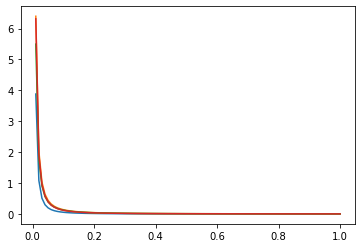

In [91]:
for pv in pvalues:
    xs = np.linspace(0.01, 1, 100)
    #if pv[0] == 'invgamma':
    ys = st.invgamma(pv[2][0], loc=pv[2][1], scale=pv[2][2]).pdf(xs)
    plt.plot(xs, ys)